In [84]:
import datetime
import numpy as np
import pandas as pd
from datetime import date
import plotly.express as px
from nsepy import get_history
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [85]:
stock_name = input('Enter NSE Stock Name: ').upper()
date_entry = input('Enter a date in yyyy,m,d format')
year, month, day = map(int, date_entry.split(','))
start_date= datetime.date(year, month, day)
end_date = date.today()
# get_history(symbol = 'SBIN', start=date(2015,1,1), end=date(2022,3,1))
def stock_df(s, sd, ed):
    df = get_history(symbol=s, start=sd, end=ed)
    return df

In [86]:
data = stock_df(stock_name, start_date, end_date)
data.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2015-01-01,SBIN,EQ,311.85,312.45,315.00,310.70,314.0,314.00,313.67,6138488,1.925489e+14,58688,1877677,0.3059
2015-01-02,SBIN,EQ,314.00,314.35,318.30,314.35,315.6,315.25,316.80,9935094,3.147389e+14,79553,4221685,0.4249
2015-01-05,SBIN,EQ,315.25,316.25,316.80,312.10,312.8,312.75,313.84,9136716,2.867432e+14,88236,3845173,0.4208
2015-01-06,SBIN,EQ,312.75,310.00,311.10,298.70,299.9,299.90,305.14,15329257,4.677601e+14,169268,7424847,0.4844
2015-01-07,SBIN,EQ,299.90,300.00,302.55,295.15,301.4,300.15,299.95,15046745,4.513243e+14,147185,5631400,0.3743


In [87]:
df = data[['Open', 'High', 'Low', 'Close', 'Volume']]
df.reset_index(inplace=True)
df.drop(['Date'], axis=1, inplace=True)
df.head()

C:\Users\chinn\AppData\Local\Temp\ipykernel_2268\3798465441.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Date'], axis=1, inplace=True)


,Open,High,Low,Close,Volume
0,312.45,315.00,310.70,314.00,6138488
1,314.35,318.30,314.35,315.25,9935094
2,316.25,316.80,312.10,312.75,9136716
3,310.00,311.10,298.70,299.90,15329257
4,300.00,302.55,295.15,300.15,15046745


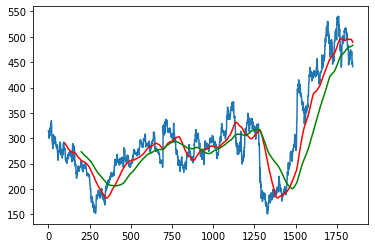

In [88]:
plt.plot(df.Close)
plt.plot(df.Close.rolling(100).mean(), color='red')
plt.plot(df.Close.rolling(200).mean(), color='green')

In [89]:
train_df = pd.DataFrame(df.Close[0:int(len(df.Close)*0.75)])
test_df = pd.DataFrame(df.Close[int(len(df.Close)*0.75):int(len(df))])
train_df.shape, test_df.shape

((1386, 1), (462, 1))

In [90]:
train_df.head()

,Close
0,314.00
1,315.25
2,312.75
3,299.90
4,300.15


In [91]:
test_df.head()

,Close
1386,195.05
1387,203.30
1388,201.90
1389,196.50
1390,193.10


In [92]:
scaler = minmax_scaler = MinMaxScaler(feature_range=(0, 1))
train_df_scaled = scaler.fit_transform(train_df)
test_df_scaled = scaler.fit_transform(test_df)

In [93]:
X_train = []
y_train = []
for i in range(100, len(train_df_scaled)):
    X_train.append(train_df_scaled[i-100 : i])
    y_train.append(train_df_scaled[i, 0])
len(X_train), len(y_train)

(1286, 1286)

In [94]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(1286, 100, 1)

In [95]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, 
                input_shape=(X_train.shape[1], 1))) # input_shape=(timesteps, features)
model.add(Dropout(0.2))
#layer 2
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.3))
#layer 3
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.4))
#layer 4
model.add(LSTM(units=60, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(units = 1))


In [96]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 100, 128)          66560     
                                                                 
 dropout_8 (Dropout)         (None, 100, 128)          0         
                                                                 
 lstm_9 (LSTM)               (None, 100, 100)          91600     
                                                                 
 dropout_9 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_10 (LSTM)              (None, 100, 60)           38640     
                                                                 
 dropout_10 (Dropout)        (None, 100, 60)           0         
                                                                 
 lstm_11 (LSTM)              (None, 60)               

In [97]:
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=69)

Epoch 1/50
19/19 [==============================] - 13s 426ms/step - loss: 0.0567
Epoch 2/50
19/19 [==============================] - 8s 413ms/step - loss: 0.0218
Epoch 3/50
19/19 [==============================] - 9s 472ms/step - loss: 0.0172
Epoch 4/50
19/19 [==============================] - 9s 452ms/step - loss: 0.0146
Epoch 5/50
19/19 [==============================] - 9s 448ms/step - loss: 0.0135
Epoch 6/50
19/19 [==============================] - 9s 458ms/step - loss: 0.0125
Epoch 7/50
19/19 [==============================] - 9s 467ms/step - loss: 0.0111
Epoch 8/50
19/19 [==============================] - 9s 466ms/step - loss: 0.0140
Epoch 9/50
19/19 [==============================] - 9s 468ms/step - loss: 0.0109
Epoch 10/50
19/19 [==============================] - 9s 475ms/step - loss: 0.0112
Epoch 11/50
19/19 [==============================] - 9s 469ms/step - loss: 0.0104
Epoch 12/50
19/19 [==============================] - 9s 475ms/step - loss: 0.0098
Epoch 13/50
19/19 [=====

In [98]:
train_df.tail(100)

,Close
1286,223.35
1287,215.15
1288,215.20
1289,203.65
1290,209.85
...,...
1381,191.60
1382,191.45
1383,190.95
1384,190.65


In [99]:
past_100 = train_df.tail(100)

In [100]:
final_df = past_100.append(test_df, ignore_index=True)
final_df.head()

C:\Users\chinn\AppData\Local\Temp\ipykernel_2268\2591333897.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = past_100.append(test_df, ignore_index=True)


,Close
0,223.35
1,215.15
2,215.20
3,203.65
4,209.85


In [101]:
input_data = scaler.fit_transform(final_df)
len(input_data)

562

In [102]:
X_test = []
y_test = []
for i in range(100, len(input_data)):
    X_test.append(input_data[i-100 : i])
    y_test.append(input_data[i, 0])

In [103]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((462, 100, 1), (462,))

In [104]:
y_pred = model.predict(X_test)

In [105]:
scaler.scale_

array([0.00256608])

In [106]:
scale_factor = 1/0.00256608
y_pred = y_pred*scale_factor
y_test = y_test*scale_factor

In [107]:
y_pred.shape, y_test.shape

((462, 1), (462,))

In [108]:
import math
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
rmse

15.459902580507569

Text(0, 0.5, 'Price')

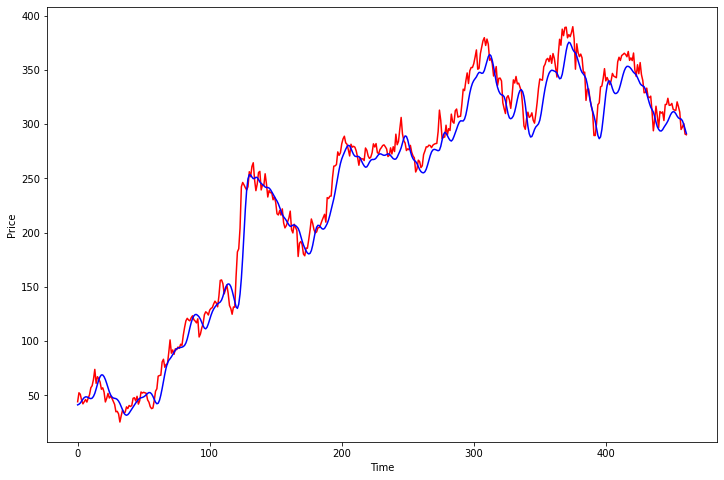

In [109]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='red', label='Actual')
plt.plot(y_pred, color='blue', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Price')

In [114]:
d = stock_df(stock_name, start_date, end_date)
df = d[['Open', 'High', 'Low', 'Close', 'Volume']]
df

,Open,High,Low,Close,Volume
Date,,,,,
2015-01-01,312.45,315.00,310.70,314.00,6138488
2015-01-02,314.35,318.30,314.35,315.25,9935094
2015-01-05,316.25,316.80,312.10,312.75,9136716
2015-01-06,310.00,311.10,298.70,299.90,15329257
2015-01-07,300.00,302.55,295.15,300.15,15046745
...,...,...,...,...,...
2022-06-13,454.00,454.05,442.10,445.85,13426836
2022-06-14,445.00,449.25,443.35,448.10,11351101
2022-06-15,448.95,455.45,448.60,451.35,9920926


C:\Users\chinn\AppData\Local\Temp\ipykernel_2268\2021093218.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MA100'] = df['Close'].rolling(short_window).mean()
C:\Users\chinn\AppData\Local\Temp\ipykernel_2268\2021093218.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MA200'] = df['Close'].rolling(long_window).mean()
C:\Users\chinn\AppData\Local\Temp\ipykernel_2268\2021093218.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

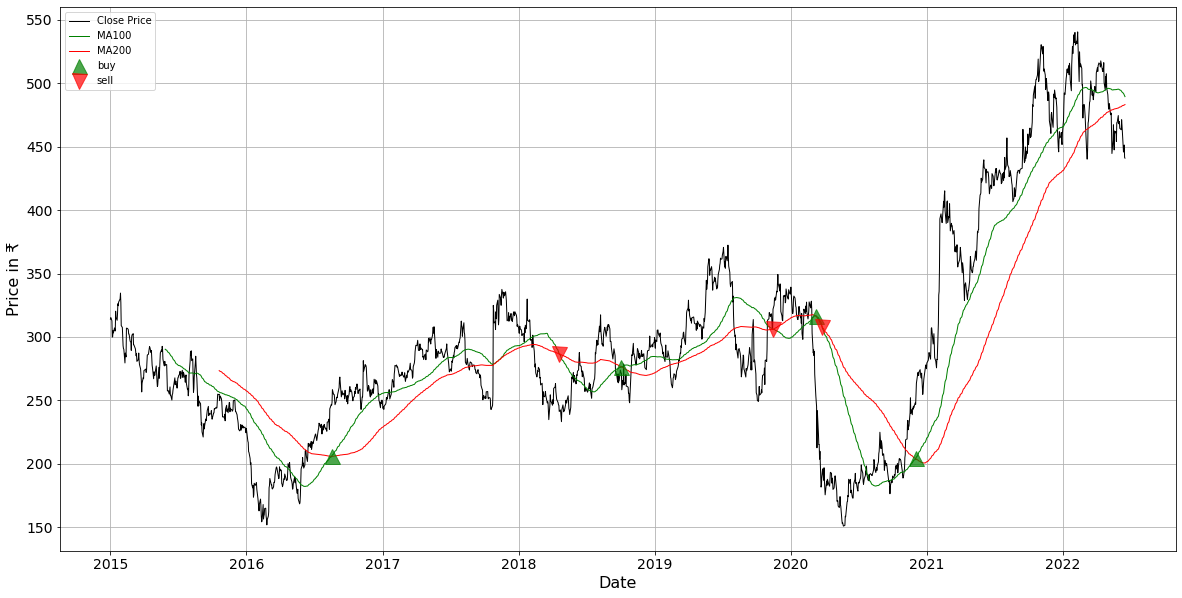

In [115]:
# Indicator 1 - Momentum
# Moving Averages
def moving_average(df, short_window = 100, long_window = 200):
    df['MA100'] = df['Close'].rolling(short_window).mean()
    df['MA200'] = df['Close'].rolling(long_window).mean()
    df['MA20'] = df['Close'].rolling(20).mean()
    df['Signal'] = 0
    df['Signal'] = np.where(df['MA100'] > df['MA200'], 1, 0)
    df['Position'] = df['Signal'].diff()

    plt.figure(figsize = (20,10))
    plt.tick_params(axis = 'both', labelsize = 14)
    df['Close'].plot(color = 'k', lw = 1, label = 'Close Price')  
    df['MA100'].plot(color = 'g', lw = 1, label = 'MA100')
    df['MA200'].plot(color = 'r', lw = 1, label = 'MA200') 

    # plot 'buy' signals
    plt.plot(df[df['Position'] == 1].index, 
            df['MA100'][df['Position'] == 1], 
            '^', markersize = 15, color = 'g', alpha = 0.7, label = 'buy')

    # plot 'sell' signals
    plt.plot(df[df['Position'] == -1].index, 
            df['MA100'][df['Position'] == -1], 
            'v', markersize = 15, color = 'r', alpha = 0.7, label = 'sell')
    plt.ylabel('Price in ₹', fontsize = 16 )
    plt.xlabel('Date', fontsize = 16 )
    plt.legend()
    plt.grid()
    plt.show()

moving_average(df)

In [ ]:
# Indicator 2 - Momentum
# Relative Strength Index
rsi = RSIIndicator(df['Close'], 14).rsi()
def relative_strength_index(df, rsi):
    if(rsi[-7:].mean() > 80):
        print('Alert : Do Not buy this stock, market value exceeded 80%')
    if(rsi[-7:].mean() < 20):
        print('Alert : Do Not sell this stock, market value below 20%')
    else:
        if(rsi[-7:].mean() > 50):
            return 'Prefer Buy'
        elif(rsi[-7:].mean() < 50):
            return 'Prefer Sell'
        else:
            return 'Prefer Hold'
    
relative_strength_index(df, rsi)

NameError: name 'RSIIndicator' is not defined